
# Muliturbanpy: multi-scale analysis of urban landscapes

The emerging field of "urban ecology" integrates natural and social sciences to study urban environments [1-4]. When studying urban areas, we are often interested in establishing relationships between the spatial organization of cities and the socioeconomic and environmental processes that occur upon them. In line with landscape ecology, identifying characteristic scales the processes of interest operate is a crucial requirement towards establishing statistical inference between urban spatial patterns and process [5, 6]. Nonetheless, spatial interactions can operate across multiple scales and in practice characteristic scales may not be easy to identify. Therefore a common approach is to consider multiple spatial scales.

The central idea of multiurbanpy is to facilitate mutli-scale analysis of urban landscapes in Python. Many concepts are inspired from landscape ecology (e.g., see the [mulilandR package](https://github.com/phuais/multilandR) [7] or [the multi-scale analysis draft of pylandstats](https://github.com/martibosch/pylandstats-notebooks/blob/main/notebooks/06-multiscale-analysis.ipynb) [8]), but adapted to urban landscapes. As an example use case, we will explore the multi-scale interactions between temperature measurements from official and citizen weather stations (CWS) and the spatial pattern of an urban landscape in Zurich, Switzerland. To that end, we will use data from swisstopo to compute the amount of buildings (in footprint area and volume), tree canopy proportion and several topographic features. Each feature will be computed at multiple scales for each meteorological station, i.e., in the surrounding urban landscape for multiple buffer distances.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import requests

requests.packages.urllib3.util.connection.HAS_IPV6 = False

In [ ]:
import logging as lg
import os
from collections.abc import Callable, Mapping

import contextily as cx
import geopandas as gpd
import numpy as np
import numpy.typing as npt
import pandas as pd
import pooch
import seaborn as sns
from meteora.clients import GHCNHourlyClient, NetatmoClient
from shapely import geometry
from sklearn import decomposition, linear_model, model_selection, preprocessing

import multiurbanpy as mup
from multiurbanpy import settings

# disable pooch logs
logger = pooch.get_logger()
logger.setLevel("WARNING")

# enable multiurbanpy logs
lg.basicConfig(level=lg.INFO)
settings.LOG_CONSOLE = True


def get_X_df(
    features_df: pd.DataFrame,
    *,
    scaler_class: Callable | bool | None = None,
    **scaler_kwargs: Mapping,
) -> pd.DataFrame:
    """Get multi-scale features for analysis with scikit-learn.

    Returns a flat (one row per grid cell/sample) data frame, which keeps only one
    buffer distance for the elevation feature (to avoid artificially duplicating
    features and inflating colinearity). Optionally use a scikit-learn preprocessing
    class to scale, center, normalize (or the like) the data (by default, use normal
    Gaussian standardization).
    """
    flat_grid_df = features_df.unstack("buffer_dist").drop(
        [("elevation", buffer_dist) for buffer_dist in buffer_dists[1:]], axis="columns"
    )
    if scaler_class is None:
        scaler_class = preprocessing.StandardScaler
    if scaler_class:
        X = scaler_class(**scaler_kwargs).fit_transform(flat_grid_df)
    else:
        X = flat_grid_df
    return pd.DataFrame(
        X,
        index=flat_grid_df.index,
        columns=flat_grid_df.columns,
    )


def aic(
    model: Callable,
    X_train: npt.ArrayLike,
    y_train: npt.ArrayLike,
    X_test: npt.ArrayLike,
    y_test: npt.ArrayLike,
    **fit_kwargs: Mapping,
) -> float:
    """Compute Akaike Information Criterion (AIC) for the test set."""
    return 2 * X_train.shape[1] - 2 * np.log(
        np.sum(
            (y_test - model().fit(X_train, y_train, **fit_kwargs).predict(X_test)) ** 2,
            axis=0,
        )
    )

In [ ]:
region = [8.46617, 47.34707, 8.57655, 47.44401]
crs = "epsg:2056"

# Netatmo credentials
client_id = os.getenv("NETATMO_CLIENT_ID", default="")
client_secret = os.getenv("NETATMO_CLIENT_SECRET", default="")
scale = "1hour"  # default is "30min"

# to compute features
# download data from zenodo
_zenodo_base_url = "https://zenodo.org/records/15166651/files"
# ACHTUNG: computing topographic features requires a windowed reading that does not work
# if we stream the geotiff directly from zenodo, so it is better to download files
# locally
buildings_url = f"{_zenodo_base_url}/buildings.gpkg?download=1"
dem_url = f"{_zenodo_base_url}/dem.tif?download=1"
tree_canopy_url = f"{_zenodo_base_url}/tree-canopy.tif?download=1"
buildings_filepath = pooch.retrieve(
    url=buildings_url,
    known_hash=None,
)
dem_filepath = pooch.retrieve(
    url=dem_url,
    known_hash=None,
)
tree_canopy_filepath = pooch.retrieve(
    url=tree_canopy_url,
    known_hash=None,
)
tree_val = 1  # value that represents a tree in the canopy raster
buffer_dists = [25, 50, 100, 250, 500]
grid_res = 200

# for PCA
target_evr = 0.9

## Getting example data

As introduced above, multiurbanpy can be used any analysis case in which we have a set of site locations (can be any site where data is collected, e.g., environmental sensors, traffic cameras or the like) for which we want to compute features of the urban spatial pattern (buildings, vegetation, topography...) at multiple spatial scales (buffers of increasing radii around each site). Additionally, we are usually interested in linking the computed multi-scale spatial features with an environmental, socioeconomic or any kind of process that occurs upon the urban landscape.

Accordingly, as an example use case, we will explore the spatial patterns that surround meteorological stations and assess how they relate to the observed temperature, e.g., through the urban heat island (UHI) effect. We will use [meteora](https://github.com/martibosch/meteora) to retrieve data from official weather stations from the [Global Historical Climatology Network hourly (GHCNh)](https://www.ncei.noaa.gov/products/global-historical-climatology-network-hourly) and [CWS from Netatmo](https://weathermap.netatmo.com). Before querying actual measurements, let us start by focusing on the available station locations:

Gtk-Message: 09:15:57.063: Failed to load module "canberra-gtk-module"
Gtk-Message: 09:15:57.065: Failed to load module "canberra-gtk-module"


Opening in existing browser session.


Enter authorization code:  8a4c55d5b39684af253126b3b9001299


100%|███████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.75it/s]


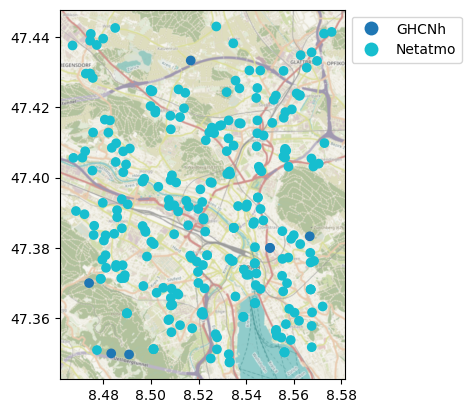

In [ ]:
ghcnh_client = GHCNHourlyClient(region)
netatmo_client = NetatmoClient(
    region,
    client_id,
    client_secret,
)
stations_gdf = pd.concat(
    [
        gdf.assign(source=source)
        for source, gdf in zip(
            ["GHCNh", "Netatmo"],
            [ghcnh_client.stations_gdf, netatmo_client.stations_gdf],
        )
    ]
)
ax = stations_gdf.plot("source", legend=True)
cx.add_basemap(ax, crs=stations_gdf.crs, attribution=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

*(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France*

### Computing multi-scale urban features

As we can see, the spatial density of CWS from Netatmo is much higher than that of official stations from the GHCNh network. We will now compute, at multiple scales around each station, the building areas and volumes, proportion of tree canopy and topographic features, i.e., slope, northness and topographic position index (TPI). To that end, we first need the following datasets:

- a **building footprints** geo-data frame, ideally with height information to compute building volumes (otherwise, only area-based features are computed). This is actually an optional requirement - if not provided, the building footprints for the given region will be automatically retrieved (without heihgt information) from the [OpenStreetMap](https://openstreetmap.org) using [osmnx](https://github.com/gboeing/osmnx).
- a **tree canopy** raster
- a **digital elevation model (DEM)** raster

Luckily, since our study area is in Switzerland, we can easily obtain the above datasets from [the swisstopo STAC API](https://www.geo.admin.ch/en/rest-interface-stac-api) using [swisstopopy](https://github.com/martibosch/swisstopopy) (see [doi.org/10.5281/zenodo.15166651](https://doi.org/10.5281/zenodo.15166651)). Given the required data, the multi-scale features can be computed using the `MultiScaleFeatureComputer` class:

In [ ]:
# reproject the region first
reproj_region = gpd.GeoSeries([geometry.box(*region)], crs="epsg:4326").to_crs(crs)
# get station locations as a geo-series
site_gser = stations_gdf["geometry"].to_crs(crs)

# initialize the mutli-scale feature computer for our (reprojected) region
msfc = mup.MultiScaleFeatureComputer(
    region=reproj_region,
    crs=crs,
)
# compute multi-scale features
building_features_df = msfc.compute_building_features(
    site_gser, buffer_dists, building_gdf=buildings_filepath
)
tree_features_df = msfc.compute_tree_features(
    tree_canopy_filepath, site_gser, buffer_dists, tree_val
)
topo_features_df = msfc.compute_topo_features_df(dem_filepath, site_gser, buffer_dists)
# compute the elevation at the station location (independent of the buffer radii):
elevation_ser = msfc.compute_elevation_ser(dem_filepath, site_gser)

# assemble into a single data frame
station_features_df = pd.concat(
    [building_features_df, tree_features_df, topo_features_df], axis="columns"
).fillna(0)
# set elevation (even though is not multi-scale)
station_features_df["elevation"] = station_features_df.index.get_level_values(
    "station_id"
).map(elevation_ser)
station_features_df

100%|███████████████████████████████████████████████| 254/254 [00:12<00:00, 21.00it/s]


building_area  building_volume  tree_canopy  \
station_id        buffer_dist                                                
70:ee:50:00:22:66 25                4.991972        40.464684     0.105934   
                  50               10.982338        78.490899     0.119812   
                  100              40.934170       270.255233     0.124523   
                  250             192.690118      1331.556136     0.115783   
                  500             553.110494      4105.899695     0.132623   
...                                      ...              ...          ...   
SZM00006677       100               0.000000         0.000000     0.242106   
                  250               0.000000         0.000000     0.208709   
SZU24-00037       25                0.000000         0.000000     0.214414   
                  50                0.000000         0.000000     0.213522   
                  100               0.000000         0.000000     0.227050   

                                  slope  northness       tpi   elevation  
station_id        buffer_dist                                             
70:ee:50:00:22:66 25           0.265110  -0.309930 -0.027985  456.230194  
                  50           0.244481  -0.183817  0.095245  456.230194  
                  100          0.241793  -0.044411  0.396912  456.230194  
                  250          0.198055   0.165987 -2.383026  456.230194  
                  500          0.177147   0.337847 -8.104401  456.230194  
...                                 ...        ...       ...         ...  
SZM00006677       100          0.677402  -0.596778 -1.124023  657.812256  
                  250          0.545901  -0.231386  6.871155  657.812256  
SZU24-00037       25           0.249751   0.757637 -1.022095  576.112732  
                  50           0.262202   0.787692 -1.810303  576.112732  
                  100          0.267347   0.828181 -2.454285  576.112732  

[1270 rows x 7 columns]

### Maximizing site variation

In order to improve the statistical significance of the relationships between spatial patterns and the processes of interests, the selected sites and scale should cover the maximum possible range of landscape heterogeneity to maximize the variance of independent variables [6]. Let us use a regular grid to explore the potential heterogeneity of our area:

In [ ]:
grid_gser = msfc.generate_regular_grid_gser(grid_res, geometry_type="point")
grid_features_df = pd.concat(
    [
        msfc.compute_building_features(
            grid_gser, buffer_dists, building_gdf=buildings_filepath
        ),
        msfc.compute_tree_features(
            tree_canopy_filepath, grid_gser, buffer_dists, tree_val
        ),
        msfc.compute_topo_features_df(dem_filepath, grid_gser, buffer_dists),
    ],
    axis="columns",
).fillna(0)
elevation_ser = msfc.compute_elevation_ser(dem_filepath, grid_gser)
# set elevation (even though is not multi-scale)
grid_features_df["elevation"] = grid_features_df.index.get_level_values(
    grid_gser.index.name
).map(elevation_ser)
grid_features_df

100%|█████████████████████████████████████████████| 2235/2235 [02:31<00:00, 14.71it/s]


building_area  building_volume  tree_canopy  \
grid_cell_id buffer_dist                                                
0            50                0.998394         9.012018     0.074866   
             100               2.995183        20.631557     0.073689   
             250              28.953437       201.039607     0.075880   
             500              97.842651       788.673371     0.044271   
1            50                1.996789        14.421914     0.036797   
...                                 ...              ...          ...   
2234         25                0.000000         0.000000     0.000000   
             50                0.000000         0.000000     0.000000   
             100               0.000000         0.000000     0.000000   
             250               0.000000         0.000000     0.000000   
             500               0.000000         0.000000     0.000000   

                                 slope  northness       tpi   elevation  
grid_cell_id buffer_dist                                                 
0            50           4.490020e-02   0.253041 -0.337982  434.526764  
             100          6.229774e-02   0.020479 -0.141083  434.526764  
             250          6.640944e-02   0.035736  0.013306  434.526764  
             500          6.540373e-02   0.022148 -1.379944  434.526764  
1            50           6.750869e-02   0.094509 -0.984161  433.573456  
...                                ...        ...       ...         ...  
2234         25           8.195799e-07   0.064830  0.000000  405.944641  
             50           3.910201e-07   0.029541 -0.000031  405.944641  
             100          5.120028e-07   0.032634 -0.000031  405.944641  
             250          7.031949e-07   0.018293  0.000000  405.944641  
             500          5.445010e-06   0.027161 -0.000397  405.944641  

[11175 rows x 7 columns]

We will now perform a principal component analysis (PCA) over the grid's computed features to explore their variability:

In [ ]:
# use a flat (one row per grid cell/sample) data frame in line with sklearn
# also keep only one buffer distance for the elevation feature (to avoid artificially
# duplicating features and inflating colinearity)
X_grid_df = get_X_df(grid_features_df)

for n_components in range(1, len(X_grid_df.columns)):
    pca = decomposition.PCA(n_components=n_components).fit(X_grid_df)
    evr = pca.explained_variance_ratio_.sum()
    if evr >= target_evr:
        break
X_grid_pca = pd.DataFrame(pca.transform(X_grid_df), index=X_grid_df.index)
n_components, pca.explained_variance_ratio_[:2].sum().item()

(7, 0.5324034802604612)

As we can se, we need 7 components to reach the target explained variance ratio (EVR) of 90%, and that the first two components explain a 53.24 % of the total EVR. Note that we have a total of 31 features, namely 6 features at 5 scales plus the elevation. Let us now see the component loadings on each variable:

<Axes: ylabel='None-buffer_dist'>

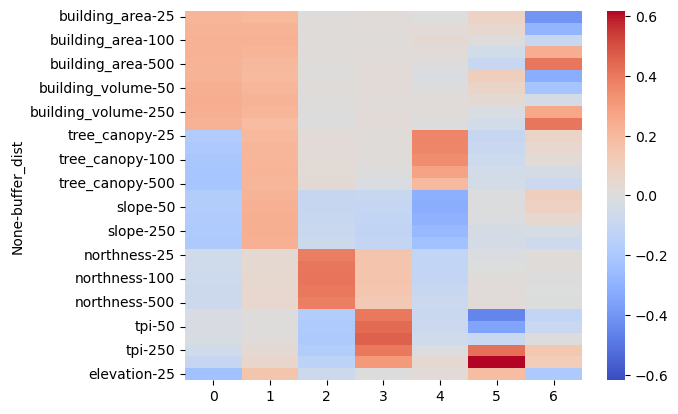

In [ ]:
load_df = pd.DataFrame(
    pca.components_.T, columns=X_grid_pca.columns, index=X_grid_df.columns
)
v = load_df.abs().max().max()
sns.heatmap(load_df, cmap="coolwarm", vmin=-v, vmax=v)

We can visualize a scatterplot of each grid cell in the first two components:

<Axes: xlabel='0', ylabel='1'>

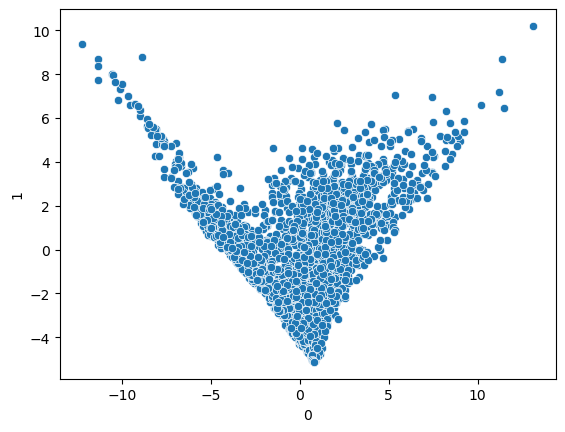

In [ ]:
sns.scatterplot(
    X_grid_pca,
    x=0,
    y=1,
)

or using the two variables that have the highest loadings on the first and second component respectively:

Text(0, 0.5, 'slope-250')

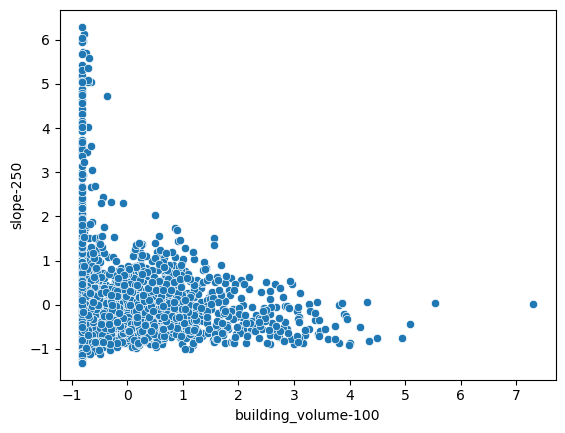

In [ ]:
x, y = (load_df.index[load_df[i].abs().argmax()] for i in range(2))
ax = sns.scatterplot(
    X_grid_df,
    x=x,
    y=y,
)
ax.set_xlabel(f"{x[0]}-{x[1]}")
ax.set_ylabel(f"{y[0]}-{y[1]}")

This gives us an idea of the variance of our landscape. We can now asses how well the existing stations cover such feature space:

<Axes: xlabel='0', ylabel='1'>

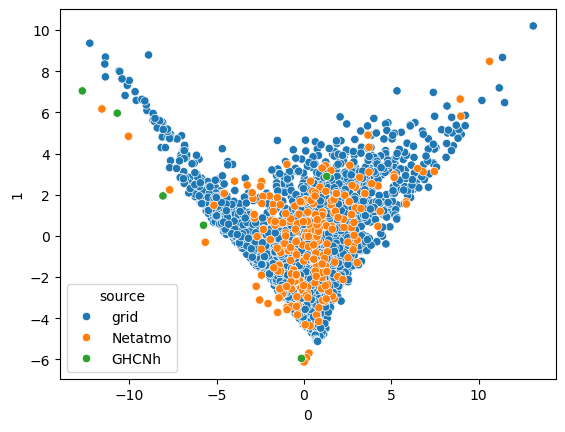

In [ ]:
X_stations_df = get_X_df(station_features_df.fillna(0))

X_stations_pca = pd.DataFrame(pca.transform(X_stations_df), index=X_stations_df.index)

sns.scatterplot(
    pd.concat(
        [
            X_grid_pca.assign(source="grid"),
            X_stations_pca.assign(
                source=X_stations_pca.index.map(stations_gdf["source"])
            ),
        ],
        ignore_index=True,
    ),
    x=0,
    y=1,
    hue="source",
)

or again, visualize a scatterplot using each component's variable with the highest loading:

Text(0, 0.5, 'slope-250')

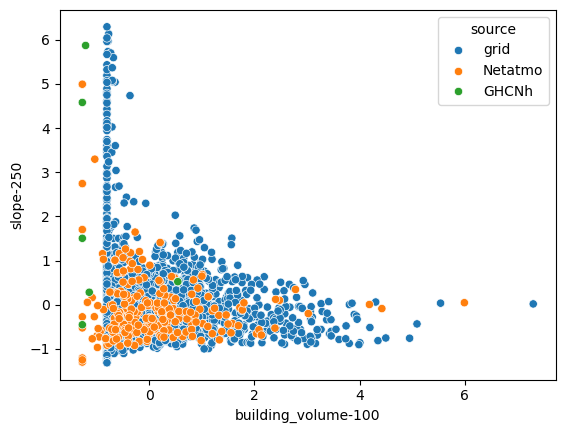

In [ ]:
# x, y = (load_df.index[load_df[i].abs().argmax()] for i in range(2))
ax = sns.scatterplot(
    pd.concat(
        [
            X_grid_df.assign(source="grid"),
            X_stations_df.assign(
                source=X_stations_df.index.map(stations_gdf["source"])
            ),
        ],
        ignore_index=True,
    ),
    x=x,
    y=y,
    hue="source",
)
ax.set_xlabel(f"{x[0]}-{x[1]}")
ax.set_ylabel(f"{y[0]}-{y[1]}")


Such visualizations illustrate how well the official stations and CWS cover the variance of our landscape. For instance, we can see that unlike CWS (Netatmo), official (GHCNh) stations only cover locations that are not too surrounded of building volume, which suggests that models based on official stations solely may not be able to provide accurate predictions under such circumstances.

In clear analogy with site selection in landscape ecology, e.g., to collect biodiversity (or other field measurements of a target ecological response) and study the effects of the surrounding spatial patterns [6, 9], we can use this information to select new locations to set up new meteorological stations.

### Scale of effect

The *scale of effect* is the scale at which the relationship between the ecological process and the landscape spatial patterns show its strongest effect [5]. It is possible to statistically estimate the *scale of effect*, e.g., by exploring at which scale the selected model exhibits the strongest determination [7]:

Let us now get a time series of data during a heatwave in August 2023, defined as at least 3 consecutive days with an average temperature over 25$^{\circ}$C ([based on the heat level warning definitions by MeteoSwiss](https://www.meteoswiss.admin.ch/weather/weather-and-climate-from-a-to-z/heat-warnings.html)):

In [ ]:
variables = ["temperature"]
start = "18-08-2023"
end = "25-08-2023"
y = pd.concat(
    [
        ts_df.groupby("station_id").mean()
        for ts_df in [
            ghcnh_client.get_ts_df(variables, start, end),
            netatmo_client.get_ts_df(variables, start, end, scale=scale),
        ]
    ]
)

[########################################] | 100% Completed | 1.11 sms


100%|██████████████████████████████████████████████| 247/247 [00:00<00:00, 276.22it/s]


We can now train a model to predict the average station temperature based on the multi-scale features and use a statistical determination measure, e.g., the Akaike information criterion (AIC), to estimate the *scale of effect*. Since this notebook is mostly a conceptual draft, let us use a simple model, i.e., linear regression and train separate instances for each scale. We will use 50 repetitions in which we shuffle the samples and then select half of them for training and the other half for testing:

<Axes: xlabel='Buffer dist.', ylabel='AIC'>

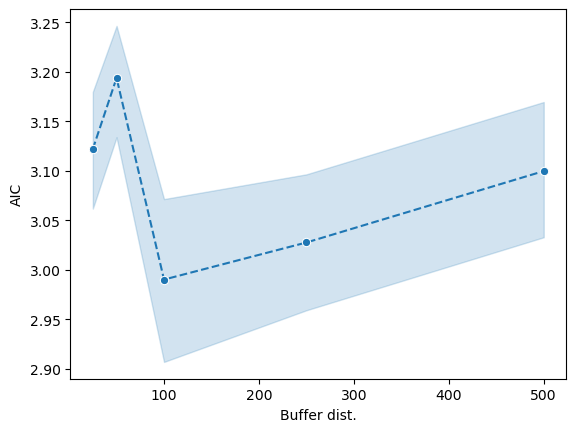

In [ ]:
n_repetitions = 50
test_size = 0.5

df = station_features_df.loc[y.index]
X_df = pd.DataFrame(preprocessing.StandardScaler().fit_transform(df), index=df.index)

# model
model = linear_model.LinearRegression

results = []
for buffer_dist, df in X_df.groupby(level="buffer_dist"):
    # drop nan
    df = df.dropna()
    _y = y.loc[df.index.get_level_values("station_id")]
    for i in range(n_repetitions):
        X_train, X_test, y_train, y_test = model_selection.train_test_split(
            df, _y, test_size=test_size, shuffle=True
        )
        results.append(
            (buffer_dist, i, aic(model, X_train, y_train, X_test, y_test).item())
        )
eval_df = pd.DataFrame(results, columns=["Buffer dist.", "repetition", "AIC"])
sns.lineplot(eval_df, x="Buffer dist.", y="AIC", marker="o", linestyle="--")

This suggests that the *scale of effect* is around 100 m, which is in line with the building volume at the 100 m scale having the highest loading on the first PCA component.

## References

1. Collins, J. P., Kinzig, A., Grimm, N. B., Fagan, W. F., Hope, D., Wu, J., & Borer, E. T. (2000). A new urban ecology: modeling human communities as integral parts of ecosystems poses special problems for the development and testing of ecological theory. American scientist, 88(5), 416-425.
2. Grimm, N. B., Faeth, S. H., Golubiewski, N. E., Redman, C. L., Wu, J., Bai, X., & Briggs, J. M. (2008). Global change and the ecology of cities. science, 319(5864), 756-760.
3. Wu, J. (2014). Urban ecology and sustainability: The state-of-the-science and future directions. Landscape and urban planning, 125, 209-221.
4. McPhearson, T., Pickett, S. T., Grimm, N. B., Niemelä, J., Alberti, M., Elmqvist, T., ... & Qureshi, S. (2016). Advancing urban ecology toward a science of cities. BioScience, 66(3), 198-212.
5. Jackson, H. B., & Fahrig, L. (2015). Are ecologists conducting research at the optimal scale?. Global Ecology and Biogeography, 24(1), 52-63.
6. Hesselbarth, M. H., Nowosad, J., de Flamingh, A., Simpkins, C. E., Jung, M., Gerber, G., & Bosch, M. (2025). Computational Methods in Landscape Ecology. Current Landscape Ecology Reports, 10(1), 1-18.
7. Huais, P. Y. (2024). Multilandr: An r package for multi-scale landscape analysis. Landscape Ecology, 39(8), 140.
8. Bosch, M. (2019). PyLandStats: An open-source Pythonic library to compute landscape metrics. PloS one, 14(12), e0225734.
9. Pasher, J., Mitchell, S. W., King, D. J., Fahrig, L., Smith, A. C., & Lindsay, K. E. (2013). Optimizing landscape selection for estimating relative effects of landscape variables on ecological responses. Landscape ecology, 28, 371-383.